In [1]:
from dotenv import load_dotenv

load_dotenv()  # take environment variables from .env.

True

In [2]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [3]:
from langchain_core.tools import BaseTool


class CustomSearch(BaseTool):
    """Tool that queries the CustomSearch."""

    name: str = "custom_search"
    description: str = (
        "a search engine. "
        "useful for when you need to answer questions about current events."
        " input should be a search query."
    )

    def _run(
        self,
        query: str,
    ) -> str:
        """Use the tool."""
        return f"custom_search_wrapper.run({query})"


tool = CustomSearch()
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

"custom_search_wrapper.run(What's a 'node' in LangGraph?)"

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from typing import Final

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


NODE_CHATBOT: Final = "chatbot"
graph_builder.add_node(NODE_CHATBOT, chatbot)

In [5]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import START


tool_node = ToolNode(tools=[tool])
NODE_TOOLS: Final = "tools"
graph_builder.add_node(NODE_TOOLS, tool_node)

graph_builder.add_conditional_edges(
    NODE_CHATBOT,
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge(NODE_TOOLS, NODE_CHATBOT)
graph_builder.add_edge(START, NODE_CHATBOT)

graph = graph_builder.compile(checkpointer=memory)

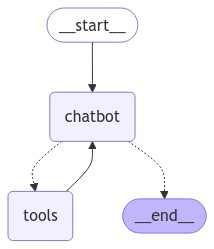

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
config = {"configurable": {"thread_id": "1"}}
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! How can I assist you today?


In [8]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Will! How can I help you today?


In [9]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don't have the ability to remember personal information or previous interactions. However, I'm here to help you with any questions or topics you'd like to discuss!


In [10]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='2ec9ec78-0cb9-40ff-b3c1-df1a6753ad4f'), AIMessage(content='Hello Will! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 68, 'total_tokens': 79, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_483d39d857', 'finish_reason': 'stop', 'logprobs': None}, id='run-09bc41c9-daf5-48ca-a9d1-ae87675f4999-0', usage_metadata={'input_tokens': 68, 'output_tokens': 11, 'total_tokens': 79}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='ce3a7d4f-15a3-4c1b-abf0-b9c1e7f7b62f'), AIMessage(content='Yes, I remember your name is Will! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_toke

In [11]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()